In [1]:
import cv2
import os, glob
import mediapipe as mp
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16


In [13]:
real_dir = r"D:\datasets\deepfakes_imgs\Dataset\Train\real_sampled"
fake_dir = r"D:\datasets\deepfakes_imgs\Dataset\Train\fake_sampled"

In [14]:
real_paths = glob.glob(os.path.join(real_dir, '*jpg'))
fake_paths = glob.glob(os.path.join(fake_dir, '*jpg'))

In [16]:
print(len(real_paths), len(fake_paths))

35001 35001


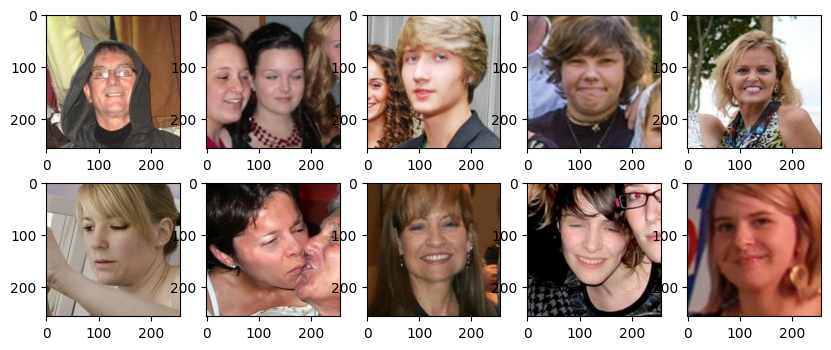

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(0,5):
    axes[0,i].imshow(cv2.cvtColor(cv2.imread(real_paths[i]), cv2.COLOR_BGR2RGB))
    axes[1,i].imshow(cv2.cvtColor(cv2.imread(fake_paths[i]), cv2.COLOR_BGR2RGB))

In [20]:
img_width, img_height = 150, 150
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True
)

train_path = r"D:\datasets\deepfakes_imgs\Dataset\Sampled_train"

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the parent directory containing class folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Assuming you have two classes
)


Found 70002 images belonging to 2 classes.


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150 , 3))

In [9]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [26]:
model = Sequential([
    base_model,
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    # layers.Dense(400, activation='relu'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(2, activation='softmax')
]
)



model.compile(
    optimizer = 'Adam',
    metrics = 'accuracy',
    loss = 'sparse_categorical_crossentropy'
)


In [27]:
print(train_generator.class_indices)

{'fake_sampled': 0, 'real_sampled': 1}


In [28]:
with tf.device('/GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=5
    )

C:\Users\Siddhartha Devan V\AppData\Local\Temp\ipykernel_12332\3163147583.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
2187/2187 [==============================] - 489s 215ms/step - loss: 0.3993 - accuracy: 0.8106
Epoch 2/5
2187/2187 [==============================] - 460s 210ms/step - loss: 0.3376 - accuracy: 0.8452
Epoch 3/5
2187/2187 [==============================] - 877s 401ms/step - loss: 0.3132 - accuracy: 0.8576
Epoch 4/5
2187/2187 [==============================] - 450s 206ms/step - loss: 0.2957 - accuracy: 0.8678
Epoch 5/5
2187/2187 [==============================] - 450s 206ms/step - loss: 0.2801 - accuracy: 0.8753


In [29]:
model.save('vgg16_deep_imgs')

INFO:tensorflow:Assets written to: vgg16_deep_imgs\assets


INFO:tensorflow:Assets written to: vgg16_deep_imgs\assets


In [30]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

test_path = r"D:\datasets\deepfakes_imgs\Dataset\Test"

In [31]:
test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to the parent directory containing class folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Assuming you have two classes
    shuffle = False
)


Found 10905 images belonging to 2 classes.


In [32]:
test_generator.class_indices

{'Fake': 0, 'Real': 1}

In [33]:
res = model.evaluate_generator(test_generator)

C:\Users\Siddhartha Devan V\AppData\Local\Temp\ipykernel_12332\9663080.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  res = model.evaluate_generator(test_generator)


In [34]:
print(res)

[0.468436062335968, 0.78670334815979]


In [35]:
Y_test  = test_generator.classes

In [36]:
Y_pred = model.predict_generator(test_generator)

C:\Users\Siddhartha Devan V\AppData\Local\Temp\ipykernel_12332\3358749156.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


In [37]:
Y_pred_labels = [np.argmax(i) for i in Y_pred]

In [38]:
print(Y_pred_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

In [39]:
from sklearn.metrics import classification_report

In [40]:
report = classification_report(Y_test, Y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5492
           1       0.80      0.76      0.78      5413

    accuracy                           0.79     10905
   macro avg       0.79      0.79      0.79     10905
weighted avg       0.79      0.79      0.79     10905

